*** Méthodes Numériques: Module 3 ***

# Sod' s Shock tube par la méthode de Richtmyer  #

### Introduction:###
Dans ce module, nous allons résoudre le problème du "Shock tube". Il s'agit d'un problème intéressant car il possède une solution analytique et permet donc d'évaluer <span style="color:red">l'efficacité</span> d'une méthode numérique. Nous allons utiliser la méthode de Richtmyer qui sera décrite plus loin. Comme d'habitude, nous importons numpy, sympy, matplotlib et également <span style="color:red">les outils</span> pour créer des animations matplotlib.

In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16

from matplotlib import animation
from IPython.display import HTML

import sympy
from sympy import init_printing
init_printing()
from sympy.utilities.lambdify import lambdify

### Principe: ###
Le shock tube est un tube à une dimension rempli de gaz et comportant deux compartiments avec des pressions différentes. Au temps t=0.0s, on enlève la membrane qui sépare les deux compartiments.
La différence de pression va créer une onde de choc de la zone de haute pression vers la zone de basse pression en même temps qu'une onde d'expansion dans l'autre sens. 
Pour modèliser ce système, on utilise les équations de conservation de la masse, de l'impulsion et de l'énergie => les équations d'Euler:
\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial}{\partial x}(\rho v) &= 0 \\
\frac{\partial}{\partial t}(\rho v) + \frac{\partial}{\partial x} (\rho v^2 + p)&=0\\
\frac{\partial}{\partial t}(\rho e_T) + \frac{\partial}{\partial x} (\rho u e_T +p u)&=0
\end{align}
où v est la vitesse en direction x, $\rho$ est la densité et p est la pression du fluide et $e_T=e+u^2/2$ est l'énergie totale.


**Nb**: Nous appelons la vitesse v plutôt que u (notation utilisée dans l'énoncé) pour éviter la confusion avec le vecteur u qui sera introduit plus loin.



On voit que si on pose 
\begin{equation}\underline{\mathbf{u}} = \left[ \begin{array}{c}
\rho \\
\rho v \\
\rho e_T \\ 
\end{array} \right]\end{equation}
et
\begin{equation}\underline{\mathbf{f}} = \left[ \begin{array}{c}
\rho v \\
\rho v^2 + p \\
(\rho e_T + p) v \\ \end{array} \right]
\end{equation}
alors notre système de trois équations se réécrit simplement: 
\begin{equation}
\frac{\partial }{\partial t} \underline{\mathbf{u}} + \frac{\partial }{\partial x} \underline{\mathbf{f}} = 0
\end{equation}
qui est l'équation que nous allons résoudre.

### Fonctions:

Nous créons une fonction u qui a pour arguments la densité, la vitesse et la pression et qui renvoie le vecteur u comme défini ci-dessus.

In [2]:
def vector_u(rho,v,p):
    u=numpy.array([rho,rho*v,rho*(p/(0.4*rho)+0.5*(v)**2)])
    return u

Ensuite nous créons une fonction qui prend le vecteur u qu'on vient de calculer et qui calcule le f correspondant, en effet on peut exprimer f comme une fonction de u comme ceci:
$$\underline{\mathbf{f}} = \left[ \begin{array}{c}
f_1 \\
f_2 \\
f_3 \\ \end{array} \right] =
\left[ \begin{array}{c}
u_2\\
\frac{u^2_2}{u_1} + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1} \right) \\
\left(u_3 + (\gamma -1)\left(u_3 - \frac{1}{2} \frac{u^2_2}{u_1}\right) \right) \frac{u_2}{u_1}\\ \end{array}
\right]$$
Et il sera très pratique d'avoir cette fonction sous la main pour appliquer la méthode de Richtmyer.

In [3]:
def computef(u):
    # on définit f comme fonction de u, donné par la formule précédente
    f=numpy.zeros_like((u))
    f[0]=u[1]
    f[1]=u[1]**2/u[0]+0.4*(u[2]-0.5*u[1]**2/u[0])
    f[2]=(u[1]/u[0])*(u[2]+0.4*(u[2]-0.5*u[1]**2/u[0]))
    return f

### Méthode de Richtmyer:

Nous allons à présent résoudre notre équation en utilisant la méthode de Richtmyer. Celle-ci utilise un pas intermédiaire pour calculer l'étape suivante. Cette méthode, contrairement à celle de discrétisation en avant dans le temps et en arrière dans l'espace, reste valable lorsqu'on a des ondes se propageant dans les deux sens selon x, ce qui est le cas ici.

\begin{align}
\underline{\mathbf{u}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} &= \frac{1}{2} \left( \underline{\mathbf{u}}^n_{i+1} + \underline{\mathbf{u}}^n_i \right) - 
\frac{\Delta t}{2 \Delta x} \left( \underline{\mathbf{f}}^n_{i+1} - \underline{\mathbf{f}}^n_i\right) \\
\underline{\mathbf{u}}^{n+1}_i &= \underline{\mathbf{u}}^n_i - \frac{\Delta t}{\Delta x} \left(\underline{\mathbf{f}}^{n+\frac{1}{2}}_{i+\frac{1}{2}} - \underline{\mathbf{f}}^{n+\frac{1}{2}}_{i-\frac{1}{2}} \right)
\end{align}

Nous définissons la fonction Shock qui prend un vecteur initial u0 de la forme du u décrit plus haut et qui calcule l'évolution de u0 après un temps t=nt*dt par la méthode de Richtmyer. dx est le pas spatial.

In [4]:
def Shock(u0,nt,dt,dx,nx):
    uu=u0.copy()#on fait une copie pour ne pas changer la valeur de u0
    predictor=numpy.zeros((3,nx-1))
    for t in range(nt):
        vv=uu.copy()#on conserve la valeur de u du temps précédent car nous devrons l'utiliser dans la deuxième étape de/
                    #notre itération
        f=computef(uu)
        
        #Première étape: on crée une liste qui reprend les valeurs intermédiaires u(n+1/2,i+1/2):
        predictor[:,:]=0.5*(uu[:,1:]+uu[:,:-1])-0.5*dt/dx*(f[:,1:]-f[:,:-1])
        ff=computef(predictor)
        
        #Deuxième étape: on calcule à présent le pas suivant en utilisant l'étape intermédiaire:
        vv[:,1:-1]=uu[:,1:-1]-dt/dx*(ff[:,1:]-ff[:,:-1])
        
        uu=vv.copy()#on remplace uu par sa valeur au temps suivant
        
    return uu

**A présent nous effectuons l'opération inverse du calcul du vecteur u:**

A partir du vecteur u calculé au temps t=nt*dt, on calcule une matrice dont chaque ligne reprend la densité, la vitesse et la pression du gaz à la position correspondant à l'indice de la ligne:

In [5]:
def ans(u):
    v=numpy.ones((nx,3))
    v[:,0]=u[0,:]
    v[:,1]=u[1,:]/u[0,:]
    v[:,2]=0.4*(u[2,:]-0.5*u[1,:]**2/u[0,:])
    return v

### Application numérique: Réponse aux questions

Nous allons à présent essayer notre méthode sur un cas particulier. 

On commence par choisir dt, L et nx.

In [6]:
L=20 #km (from -10 to +10)
dt=0.0002 #second
nx=81 #so that we cover 20 km, from -10 to +10
dx= L/(nx-1)

In [7]:
x=numpy.linspace(-10,10,nx)

On donne les conditions initiales du gaz sous forme d'une matrice: la première ligne donne la densité à chaque position, la deuxième donne la vitesse à chaque position et le troisième donne la pression à chaque position. On calcule ensuite le vecteur u de ces conditions initiales dans v0.

In [8]:
IC=numpy.zeros((3,nx))
IC[0,:40]=1.0 #kg/m³
IC[0,40:]=0.125 #kg/m³
IC[1,0:]=0.0 #m/s
IC[2,:40]=100000.0 #N/m²
IC[2,40:]=10000.0 #N/m²
v0=vector_u(IC[0],IC[1],IC[2])

In [9]:
shock=Shock(v0,50,dt,dx,nx)
#on regarde en nt=50 car on veut aller jusqu'au temps t=0.01s par pas de 0.0002s, on doit donc réaliser 50 étapes

In [10]:
ans(shock)[50]

array([  3.74691403e-01,   2.92611472e+02,   3.02508902e+04])

### Graphiques:

In [11]:
def plot(nx):
    v=numpy.ones((3,nx))
    for j in range(nx):
            v[:,j]=ans(shock)[j,:]
    return v

In [12]:
def graph(ordonnée,legende_y,ymin,ymax,title):
    pyplot.plot(x,ordonnée, color='#003366', lw=1)
    pyplot.ylim(ymin,ymax);
    pyplot.xlabel('x (km)', fontsize=14) #x label
    pyplot.ylabel(legende_y, fontsize=14) #y label,
    pyplot.title(title, y=1.08, fontsize=15) ;

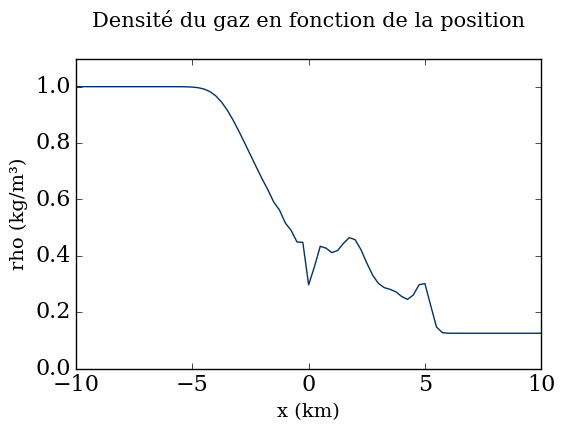

In [13]:
graph(plot(nx)[0],'rho (kg/m³)',0.0,1.1,'Densité du gaz en fonction de la position')

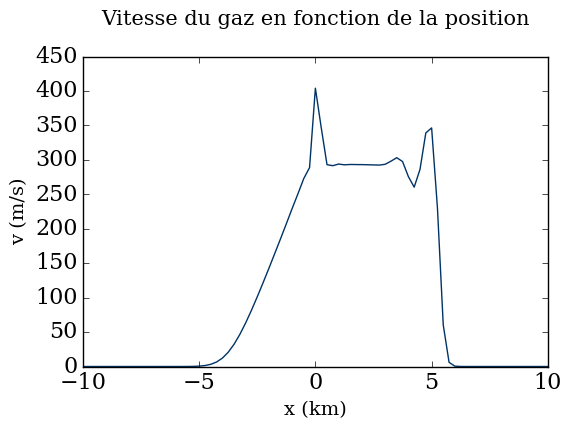

In [14]:
graph(plot(nx)[1],'v (m/s)',0.0,450.0,'Vitesse du gaz en fonction de la position')

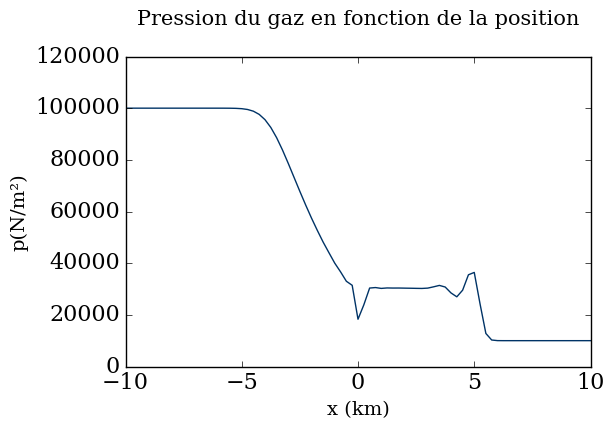

In [15]:
graph(plot(nx)[2],'p(N/m²)',0.0,120000.0,'Pression du gaz en fonction de la position')

### Evolution dans le temps:
Pour étudier l'évolution dans le temps, nous allons faire une animation. Pour l'instant ca ne marche pas mais jen ai marre :p

In [16]:
fig = pyplot.figure(figsize=(8,5))
ax = pyplot.axes(xlim=(-10,10), ylim=(0.0,1.1))
line = ax.plot([], [], color='#003366', lw=3)[0]
pyplot.xlabel('x (km)', fontsize=14) #x label
pyplot.ylabel('rho (voitures/km)', fontsize=14) #y label
pyplot.title('Densité du gaz en fonction de la position', y=1.08)
pyplot.close()

In [17]:
u=numpy.zeros((3,81))
un=numpy.zeros((3,81))
nt=50

In [18]:
def density(i):
    line.set_data(x,u)
    
    un=u.copy()
    u=Shock(v0,1,)

In [19]:
anim = animation.FuncAnimation(fig, density,frames=nt, interval=100)

In [20]:
HTML(anim.to_html5_video())

UnboundLocalError: local variable 'u' referenced before assignment